# Data source
In this notebook we will analize a representative subset of the [FooDB](https://foodb.ca/) compound library exploiting the Chemical Checker signatures generated _via_ our Signaturizers. Let's first inspect the  data:

In [1]:
import pandas as pd
df = pd.read_csv('./foodb_repr.csv')
df

,InChIKey,SMILES,food_name,food_subgroup,food_group
0,AAARRLVSWMMLIL-JFDCHTIYSA-N,CC/C=C\C/C=C\C/C=C\C/C=C\CCCCCCC(=O)OC[C@H](CO...,Bison,Bovines,Animal foods
1,AAAUQAJYMBAEDN-SDYYSCIWSA-N,CC/C=C\C/C=C\C/C=C\C/C=C\CCCCCCC(=O)OC[C@H](CO...,Bison,Bovines,Animal foods
2,AAAVAOYFDZROJH-ODEQYEIHSA-N,CCCCCCCCCCCCCCCCC(=O)OC[C@@H](COC(=O)CCCCCCCCC...,Bison,Bovines,Animal foods
3,AAAYFFAGXKLUDV-AXAMJWTMSA-N,CC(C)CCCCCCCCCCCCCCCCCC(=O)OC[C@H](COC(=O)CCCC...,Bison,Bovines,Animal foods
4,AABORWYRSOFPIQ-NTOMMRJQSA-N,CCCCCCCCCCCCCCCCCCC(=O)OC[C@@H](COC(=O)CCCCCCC...,Bison,Bovines,Animal foods
...,...,...,...,...,...
47949,IKGXIBQEEMLURG-NVPNHPEKSA-N,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,Berry wine,Fermented beverages,Beverages
47950,IKGXIBQEEMLURG-NVPNHPEKSA-N,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,Berry wine,Fermented beverages,Beverages
47951,OXGUCUVFOIWWQJ-HQBVPOQASA-N,C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)c...,Berry wine,Fermented beverages,Beverages
47952,OXGUCUVFOIWWQJ-HQBVPOQASA-N,C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)c...,Berry wine,Fermented beverages,Beverages


We have different column in this file, the most importand for our task is the **SMILES** columns. The SMILES format is a representation of the chemical structure of a compound which is our starting point.

In [2]:
df.nunique()

InChIKey         6325
SMILES           6325
food_name         461
food_subgroup      57
food_group         17
dtype: int64

Comparing the total number of rows (47954) to the number of unique entries (6325) we realize that molecules are repeated, and indeed different food can contain repeated compounds. For this reason we'll use a non redundant set of SMILES.

In [3]:
smiles = df.SMILES.unique()

# Signatures
Signatures are numerical representation of molecules. Having molecules represented as vector is needed if we want to do any quantitative analysis of our library (e.g. comparison, clustering, visualization ...). The advantage of using a signaturizer with respect to standard chemical representation (e.g. morgan fingerprint) is that we can leverage on the wealth of public bioactivity data that goes beyond chemical information.

In the Chemical Checker we defined 25 bioactivity spaces which capture multiple aspect of a molecule. The stacked version of the signatures for these 25 spaces is what we call the _global_ signature, i.e. a general purpose entry point for our analisys.

In [4]:
# load the global bioactivity signaturizer
from signaturizer import Signaturizer
sign = Signaturizer('B4', verbose=False)

For the sake of time we can just consider a random subsampling of these molecules.

In [5]:
import numpy as np
np.random.seed(42)
subsample = np.random.choice(smiles, 1000, replace=False)
result = sign.predict(subsample)

In [6]:
result.signature.shape

(1000, 128)

# Visualization
Only fantasy limits us in the way we can visualize the results generated.

In [7]:
%matplotlib inline
import matplotlib
import seaborn as sns
from matplotlib import gridspec, colors, colorbar, patches, lines
import matplotlib.pyplot as plt

We can plot the overall distribution of values for all generated signatures, and appreciate their bimodal distribution.

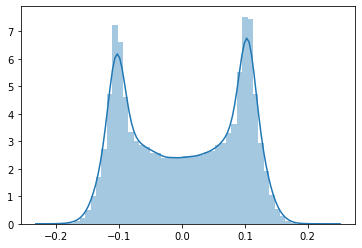

In [8]:
sns.distplot(result.signature.ravel())

Or we can look at the raw matrix.

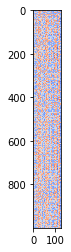

In [9]:
plt.imshow(result.signature, cmap='coolwarm')

The signatures we generated have 3200 dimensions but looking at the raw data does not inform us on how similar/different are our molecules.

In Cheminformatics we often need a graphical representation of the chemical space covered by a set of molecules.  In this representation, similar molecules will be close and molecules that are different will be far apart.

We can use scikit-learn to create a lower bi-dimensional representation which will enable such visualization.

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca_red = PCA(n_components=128).fit_transform(result.signature)
projection = TSNE(n_components=2).fit_transform(pca_red)

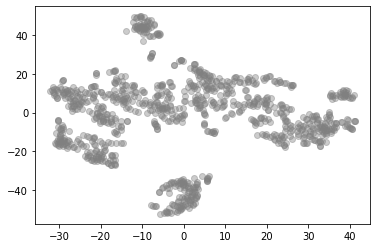

In [11]:
plt.scatter(projection[:,0],projection[:,1], color='grey', alpha=.4)

Now we can appreciate the diversity of our molecules and also that they are 'organized' with some form of structure. We can annotate molecules with the food of origin to highlight this structure.

For example let's color all molecules coming from animal origin (i.e. meat):

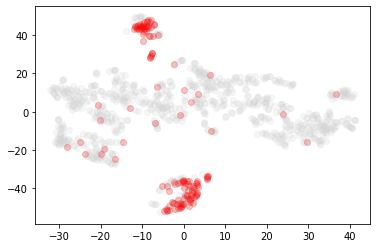

In [12]:
cat_smiles = df[df.food_group == 'Animal foods'].SMILES.unique()
cat_mask = np.isin(subsample, cat_smiles)
plt.scatter(projection[:,0],projection[:,1], color='lightgrey', alpha=.2)
plt.scatter(projection[:,0][cat_mask],projection[:,1][cat_mask], color='red', alpha=0.2)

We clearly see that molecules from this food source are localized in two clusers of our bioactivity space.

If we go forcompounds of vegetable orgin we can see, as expectable, that the two set of molecules do not overlap.

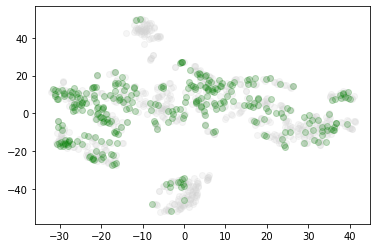

In [13]:
cat_smiles = df[df.food_group == 'Vegetables'].SMILES.unique()
cat_mask = np.isin(subsample, cat_smiles)
plt.scatter(projection[:,0],projection[:,1], color='lightgrey', alpha=.2)
plt.scatter(projection[:,0][cat_mask],projection[:,1][cat_mask], color='green', alpha=0.2)